<a href="https://colab.research.google.com/github/reshalfahsi/zero-reference-low-light-image-enhancement/blob/master/Zero_Reference_Low_Light_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Zero-Reference Low-Light Image Enhancement**

## **Important Libraries**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics gdown

In [2]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.image import (
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure
)
from torchmetrics.regression import MeanAbsoluteError

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os
import cv2
import random
import math
from glob import glob

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'

## **Dataset**

### **Download**

In [3]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip
!rm -rf lol_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /content/lol_dataset.zip
100% 347M/347M [00:03<00:00, 94.5MB/s]


### **Configuration**

In [3]:
IMAGE_SIZE = 256
PATCH_SIZE = 16
MAX_TRAIN_IDX = 384
DATASET_SEED = np.random.randint(2147483647)
print(f"Dataset seed: {DATASET_SEED}")

Dataset seed: 1548543350


In [4]:
def image_transform(img, img_width=IMAGE_SIZE, img_height=IMAGE_SIZE):
    img = cv2.resize(
        img,
        (img_width, img_height),
        interpolation = cv2.INTER_LINEAR,
    )
    img = img.transpose(2,0,1).astype('float32')
    img /= 255.
    return torch.from_numpy(img)

In [5]:
class LOLDataset(data.Dataset):
    def __init__(self, split=None, transform=None):
        super().__init__()

        assert split is not None, (
            "Please specify dataset split: train, val, test, and inference"
        )

        if split == "train":
            self._dataset = sorted(glob("./lol_dataset/our485/low/*"))
            self._reference = sorted(glob("./lol_dataset/our485/high/*"))
            random.seed(DATASET_SEED)
            random.shuffle(self._dataset)
            self._dataset = self._dataset[:MAX_TRAIN_IDX]
            random.seed(DATASET_SEED)
            random.shuffle(self._reference)
            self._reference = self._reference[:MAX_TRAIN_IDX]
        elif split == "val":
            self._dataset = sorted(glob("./lol_dataset/our485/low/*"))
            self._reference = sorted(glob("./lol_dataset/our485/high/*"))
            random.seed(DATASET_SEED)
            random.shuffle(self._dataset)
            self._dataset = self._dataset[MAX_TRAIN_IDX:]
            random.seed(DATASET_SEED)
            random.shuffle(self._reference)
            self._reference = self._reference[MAX_TRAIN_IDX:]
        elif split in ["test", "inference"]:
            self._dataset = sorted(glob("./lol_dataset/eval15/low/*"))
            self._reference = sorted(glob("./lol_dataset/eval15/high/*"))
        else:
            raise TypeError(f"Unrecognized split type: {split}")

        self._split = split
        self._transform = transform

    def set_inference_index(self, idx):
        self._inference_index = idx

    @property
    def inference_image(self):
        return cv2.imread(self._dataset[self._inference_index])

    @property
    def inference_reference(self):
        return cv2.imread(self._reference[self._inference_index])

    def __len__(self):
        return 1 if self._split == "inference" else len(self._dataset)

    def __getitem__(self, idx):
        if self._split == "inference":
            image = self.inference_image
        else:
            image = cv2.imread(self._dataset[idx])
            reference = cv2.imread(self._reference[idx])
        if self._transform is not None:
            image = self._transform(image)
            if self._split != "inference":
                reference = self._transform(reference)
        if self._split == "inference": return image
        return image, reference

In [6]:
TrainDataset = LOLDataset(split="train", transform=image_transform)
TestDataset = LOLDataset(split="test", transform=image_transform)
ValDataset = LOLDataset(split="val", transform=image_transform)

## **Loss Function**

In [7]:
class ColorConstancyLoss(nn.Module):
    """ For the enhanced image.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mean = torch.mean(x, dim=[2, 3], keepdims=True)
        bmean, gmean, rmean = mean[:, 0, ...], mean[:, 1, ...], mean[:, 2, ...]
        dbg = torch.square(bmean - gmean)
        dbr = torch.square(bmean - rmean)
        dgr = torch.square(gmean - rmean)
        return torch.mean(
            torch.sqrt(
                torch.square(dbg)
                + torch.square(dbr)
                + torch.square(dgr)
            )
        )

In [8]:
class ExposureLoss(nn.Module):
    """ For the enhanced image.
    """
    def __init__(self, patch_ratio=int(IMAGE_SIZE//PATCH_SIZE), mean_val=0.6):
        super().__init__()

        self._mean_val = mean_val
        self._patch_ratio = patch_ratio
        self._device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, x):
        x = torch.mean(x, dim=1, keepdims=True)
        x = F.avg_pool2d(x, kernel_size=self._patch_ratio, stride=self._patch_ratio)
        return torch.mean(torch.square(x - torch.FloatTensor([self._mean_val]).to(self._device)))

In [9]:
class IlluminationSmoothnessLoss(nn.Module):
    """For the curve parameter map."""

    def __init__(self):
        super().__init__()

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = (x.size()[2] - 1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, : h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, : w_x - 1]), 2).sum()
        return torch.mean(2 * (h_tv / count_h + w_tv / count_w) / batch_size)

In [10]:
class SpatialConsistencyLoss(nn.Module):
    """ For the enhanced image and the original data.
    """
    def __init__(self, region_size=4):
        super().__init__()

        self._region_size = region_size
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        kernel_left = torch.FloatTensor([
            [0,  0, 0],
            [-1, 1, 0],
            [0,  0, 0],
        ]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor([
            [0, 0, 0],
            [0, 1,-1],
            [0, 0, 0],
        ]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor([
            [0,-1, 0],
            [0, 1, 0],
            [0, 0, 0],
        ]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor([
            [0, 0, 0],
            [0, 1, 0],
            [0,-1, 0],
        ]).to(device).unsqueeze(0).unsqueeze(0)

        self.kernel_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.kernel_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.kernel_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.kernel_down = nn.Parameter(data=kernel_down, requires_grad=False)

    def forward(self, x_, x):
        x = torch.mean(x, dim=1, keepdims=True)
        x_ = torch.mean(x_, dim=1, keepdims=True)

        x = F.avg_pool2d(x, kernel_size=self._region_size, stride=self._region_size)
        x_ = F.avg_pool2d(x_, kernel_size=self._region_size, stride=self._region_size)

        xleft = torch.abs(F.conv2d(x, self.kernel_left, padding=1))
        xright = torch.abs(F.conv2d(x, self.kernel_right, padding=1))
        xup = torch.abs(F.conv2d(x, self.kernel_up, padding=1))
        xdown = torch.abs(F.conv2d(x, self.kernel_down, padding=1))

        x_left = torch.abs(F.conv2d(x_, self.kernel_left, padding=1))
        x_right = torch.abs(F.conv2d(x_, self.kernel_right, padding=1))
        x_up = torch.abs(F.conv2d(x_, self.kernel_up, padding=1))
        x_down = torch.abs(F.conv2d(x_, self.kernel_down, padding=1))

        return torch.mean(
            torch.square(x_left - xleft)
            + torch.square(x_right - xright)
            + torch.square(x_up - xup)
            + torch.square(x_down - xdown)
        )

## **Model**

### **Utils**

In [11]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

### **Zero-DCE**

In [12]:
SIGN = -1

class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        number_f = 32
        self.e_conv1 = nn.Conv2d(3, number_f, 3, 1, 1, bias=True)
        self.e_conv2 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv3 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv4 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv5 = nn.Conv2d(number_f * 2, number_f, 3, 1, 1, bias=True)
        self.e_conv6 = nn.Conv2d(number_f * 2, number_f, 3, 1, 1, bias=True)
        self.e_conv7 = nn.Conv2d(number_f * 2, 24, 3, 1, 1, bias=True)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x7 = F.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x7, 3, dim=1)

        x = x + r1 * SIGN * (x - torch.pow(x, 2))
        x = x + r2 * SIGN * (x - torch.pow(x, 2))
        x = x + r3 * SIGN * (x - torch.pow(x, 2))
        x = x + r4 * SIGN * (x - torch.pow(x, 2))
        x = x + r5 * SIGN * (x - torch.pow(x, 2))
        x = x + r6 * SIGN * (x - torch.pow(x, 2))
        x = x + r7 * SIGN * (x - torch.pow(x, 2))
        x = x + r8 * SIGN * (x - torch.pow(x, 2))
        r = torch.cat([r1, r2, r3, r4, r5, r6, r7, r8], 1)

        return x, r

In [13]:
MODEL = ZeroDCE
MODEL_NAME = ZeroDCE.__name__

### **Wrapper**

In [14]:
class ModelWrapper(L.LightningModule):
    def __init__(self, arch, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.train_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.train_mae = MeanAbsoluteError()

        self.val_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.val_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_mae = MeanAbsoluteError()

        self.test_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.test_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.test_mae = MeanAbsoluteError()

        self.automatic_optimization = False

        self.colorconstancyloss = ColorConstancyLoss()
        self.exposureloss = ExposureLoss()
        self.illuminationsmoothnessloss = IlluminationSmoothnessLoss()
        self.spatialconsistencyloss = SpatialConsistencyLoss()

        self.train_total_loss = []
        self.train_colorconstancy_loss = []
        self.train_exposure_loss = []
        self.train_illuminationsmoothness_loss = []
        self.train_spatialconsistency_loss = []

        self.val_total_loss = []
        self.val_colorconstancy_loss = []
        self.val_exposure_loss = []
        self.val_illuminationsmoothness_loss = []
        self.val_spatialconsistency_loss = []

        self.train_psnr_list = []
        self.train_ssim_list = []
        self.train_mae_list = []

        self.val_psnr_list = []
        self.val_ssim_list = []
        self.val_mae_list = []

        self.train_total_loss_recorder = AvgMeter()
        self.train_colorconstancy_loss_recorder = AvgMeter()
        self.train_exposure_loss_recorder = AvgMeter()
        self.train_illuminationsmoothness_loss_recorder = AvgMeter()
        self.train_spatialconsistency_loss_recorder = AvgMeter()

        self.val_total_loss_recorder = AvgMeter()
        self.val_colorconstancy_loss_recorder = AvgMeter()
        self.val_exposure_loss_recorder = AvgMeter()
        self.val_illuminationsmoothness_loss_recorder = AvgMeter()
        self.val_spatialconsistency_loss_recorder = AvgMeter()

        self.train_psnr_recorder = AvgMeter()
        self.train_ssim_recorder = AvgMeter()
        self.train_mae_recorder = AvgMeter()

        self.val_psnr_recorder = AvgMeter()
        self.val_ssim_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, ref = batch
        x_hat, r = self(x)

        colorconstancyloss = 5.0 * self.colorconstancyloss(x_hat)
        exposureloss = 10.0 * self.exposureloss(x_hat)
        illuminationsmoothnessloss = 200.0 * self.illuminationsmoothnessloss(r)
        spatialconsistencyloss = self.spatialconsistencyloss(x_hat, x)

        totalloss = (
            colorconstancyloss
            + exposureloss
            + illuminationsmoothnessloss
            + spatialconsistencyloss
        )

        self.train_psnr.update(x_hat, ref)
        psnr = self.train_psnr.compute().data.cpu()

        self.train_ssim.update(x_hat, ref)
        ssim = self.train_ssim.compute().data.cpu()

        self.train_mae.update(x_hat, ref)
        mae = self.train_mae.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(totalloss)
        opt.step()

        self.log("train_total_loss", totalloss, prog_bar=True)
        self.log("train_colorconstancy_loss", colorconstancyloss, prog_bar=True)
        self.log("train_exposure_loss", exposureloss, prog_bar=True)
        self.log(
            "train_illuminationsmoothness_loss",
            illuminationsmoothnessloss,
            prog_bar=True,
        )
        self.log("train_spatialconsistency_loss", spatialconsistencyloss, prog_bar=True)

        self.log("train_psnr", psnr, prog_bar=True)
        self.log("train_ssim", ssim, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)

        self.train_total_loss_recorder.update(totalloss.data)
        self.train_colorconstancy_loss_recorder.update(colorconstancyloss.data)
        self.train_exposure_loss_recorder.update(exposureloss.data)
        self.train_illuminationsmoothness_loss_recorder.update(
            illuminationsmoothnessloss.data
        )
        self.train_spatialconsistency_loss_recorder.update(spatialconsistencyloss.data)

        self.train_psnr_recorder.update(psnr)
        self.train_ssim_recorder.update(ssim)
        self.train_mae_recorder.update(mae)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_total_loss.append(
            self.train_total_loss_recorder.show().data.cpu().numpy()
        )
        self.train_total_loss_recorder = AvgMeter()
        self.train_colorconstancy_loss.append(
            self.train_colorconstancy_loss_recorder.show().data.cpu().numpy()
        )
        self.train_colorconstancy_loss_recorder = AvgMeter()
        self.train_exposure_loss.append(
            self.train_exposure_loss_recorder.show().data.cpu().numpy()
        )
        self.train_exposure_loss_recorder = AvgMeter()
        self.train_illuminationsmoothness_loss.append(
            self.train_illuminationsmoothness_loss_recorder.show().data.cpu().numpy()
        )
        self.train_illuminationsmoothness_loss_recorder = AvgMeter()
        self.train_spatialconsistency_loss.append(
            self.train_spatialconsistency_loss_recorder.show().data.cpu().numpy()
        )
        self.train_spatialconsistency_loss_recorder = AvgMeter()

        self.train_psnr_list.append(self.train_psnr_recorder.show().data.cpu().numpy())
        self.train_psnr_recorder = AvgMeter()
        self.train_ssim_list.append(self.train_ssim_recorder.show().data.cpu().numpy())
        self.train_ssim_recorder = AvgMeter()
        self.train_mae_list.append(self.train_mae_recorder.show().data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, ref = batch
        x_hat, r = self(x)

        colorconstancyloss = 5.0 * self.colorconstancyloss(x_hat)
        exposureloss = 10.0 * self.exposureloss(x_hat)
        illuminationsmoothnessloss = 200.0 * self.illuminationsmoothnessloss(r)
        spatialconsistencyloss = self.spatialconsistencyloss(x_hat, x)

        totalloss = (
            colorconstancyloss
            + exposureloss
            + illuminationsmoothnessloss
            + spatialconsistencyloss
        )

        self.val_psnr.update(x_hat, ref)
        psnr = self.val_psnr.compute().data.cpu()

        self.val_ssim.update(x_hat, ref)
        ssim = self.val_ssim.compute().data.cpu()

        self.val_mae.update(x_hat, ref)
        mae = self.val_mae.compute().data.cpu()

        self.log("val_total_loss", totalloss, prog_bar=True)
        self.log("val_colorconstancy_loss", colorconstancyloss, prog_bar=True)
        self.log("val_exposure_loss", exposureloss, prog_bar=True)
        self.log(
            "val_illuminationsmoothness_loss",
            illuminationsmoothnessloss,
            prog_bar=True,
        )
        self.log("val_spatialconsistency_loss", spatialconsistencyloss, prog_bar=True)

        self.log("val_psnr", psnr, prog_bar=True)
        self.log("val_ssim", ssim, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)

        self.val_total_loss_recorder.update(totalloss.data)
        self.val_colorconstancy_loss_recorder.update(colorconstancyloss.data)
        self.val_exposure_loss_recorder.update(exposureloss.data)
        self.val_illuminationsmoothness_loss_recorder.update(
            illuminationsmoothnessloss.data
        )
        self.val_spatialconsistency_loss_recorder.update(spatialconsistencyloss.data)

        self.val_psnr_recorder.update(psnr)
        self.val_ssim_recorder.update(ssim)
        self.val_mae_recorder.update(mae)

    def on_validation_epoch_end(self):
        self.val_total_loss.append(
            self.val_total_loss_recorder.show().data.cpu().numpy()
        )
        self.val_total_loss_recorder = AvgMeter()
        self.val_colorconstancy_loss.append(
            self.val_colorconstancy_loss_recorder.show().data.cpu().numpy()
        )
        self.val_colorconstancy_loss_recorder = AvgMeter()
        self.val_exposure_loss.append(
            self.val_exposure_loss_recorder.show().data.cpu().numpy()
        )
        self.val_exposure_loss_recorder = AvgMeter()
        self.val_illuminationsmoothness_loss.append(
            self.val_illuminationsmoothness_loss_recorder.show().data.cpu().numpy()
        )
        self.val_illuminationsmoothness_loss_recorder = AvgMeter()
        self.val_spatialconsistency_loss.append(
            self.val_spatialconsistency_loss_recorder.show().data.cpu().numpy()
        )
        self.val_spatialconsistency_loss_recorder = AvgMeter()

        self.val_psnr_list.append(self.val_psnr_recorder.show().data.cpu().numpy())
        self.val_psnr_recorder = AvgMeter()
        self.val_ssim_list.append(self.val_ssim_recorder.show().data.cpu().numpy())
        self.val_ssim_recorder = AvgMeter()
        self.val_mae_list.append(self.val_mae_recorder.show().data.cpu().numpy())
        self.val_mae_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, ref = batch
        x_hat, r = self(x)

        colorconstancyloss = 5.0 * self.colorconstancyloss(x_hat)
        exposureloss = 10.0 * self.exposureloss(x_hat)
        illuminationsmoothnessloss = 200.0 * self.illuminationsmoothnessloss(r)
        spatialconsistencyloss = self.spatialconsistencyloss(x_hat, x)

        totalloss = (
            colorconstancyloss
            + exposureloss
            + illuminationsmoothnessloss
            + spatialconsistencyloss
        )

        self.test_psnr.update(x_hat, ref)
        psnr = self.test_psnr.compute().data.cpu()

        self.test_ssim.update(x_hat, ref)
        ssim = self.test_ssim.compute().data.cpu()

        self.test_mae.update(x_hat, ref)
        mae = self.test_mae.compute().data.cpu()

        self.log("test_total_loss", totalloss, prog_bar=True, logger=True)
        self.log(
            "test_colorconstancy_loss", colorconstancyloss, prog_bar=True, logger=True
        )
        self.log("test_exposure_loss", exposureloss, prog_bar=True, logger=True)
        self.log(
            "test_illuminationsmoothness_loss",
            illuminationsmoothnessloss,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_spatialconsistency_loss",
            spatialconsistencyloss,
            prog_bar=True,
            logger=True,
        )

        self.log("test_psnr", psnr, prog_bar=True, logger=True)
        self.log("test_ssim", ssim, prog_bar=True, logger=True)
        self.log("test_mae", mae, prog_bar=True, logger=True)

    def on_train_end(self):
        # Loss
        loss_img_file = f"/content/{MODEL_NAME}_total_loss_plot.png"
        plt.plot(self.train_total_loss, color="r", label="train")
        plt.plot(self.val_total_loss, color="b", label="validation")
        plt.title("Total Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        loss_img_file = f"/content/{MODEL_NAME}_colorconstancy_loss_plot.png"
        plt.plot(self.train_colorconstancy_loss, color="r", label="train")
        plt.plot(self.val_colorconstancy_loss, color="b", label="validation")
        plt.title("Color Constancy Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        loss_img_file = f"/content/{MODEL_NAME}_exposure_loss_plot.png"
        plt.plot(self.train_exposure_loss, color="r", label="train")
        plt.plot(self.val_exposure_loss, color="b", label="validation")
        plt.title("Exposure Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        loss_img_file = f"/content/{MODEL_NAME}_illuminationsmoothness_loss_plot.png"
        plt.plot(self.train_illuminationsmoothness_loss, color="r", label="train")
        plt.plot(self.val_illuminationsmoothness_loss, color="b", label="validation")
        plt.title("Illumination Smoothness Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        loss_img_file = f"/content/{MODEL_NAME}_spatialconsistency_loss_plot.png"
        plt.plot(self.train_spatialconsistency_loss, color="r", label="train")
        plt.plot(self.val_spatialconsistency_loss, color="b", label="validation")
        plt.title("Spatial Consistency Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Evaluation Metrics
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_psnr_plot.png"
        plt.plot(self.train_psnr_list, color="r", label="train")
        plt.plot(self.val_psnr_list, color="b", label="validation")
        plt.title("PSNR Curves")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR")
        plt.legend()
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

        evaluation_metric_img_file = f"/content/{MODEL_NAME}_ssim_plot.png"
        plt.plot(self.train_ssim_list, color="r", label="train")
        plt.plot(self.val_ssim_list, color="b", label="validation")
        plt.title("SSIM Curves")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

        evaluation_metric_img_file = f"/content/{MODEL_NAME}_mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list, color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-4,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.11),
                    int(self.max_epoch * 0.23),
                    int(self.max_epoch * 0.31),
                    int(self.max_epoch * 0.43),
                    int(self.max_epoch * 0.53),
                    int(self.max_epoch * 0.61),
                    int(self.max_epoch * 0.71),
                    int(self.max_epoch * 0.83),
                    int(self.max_epoch * 0.97),
                ],
                gamma=(1.0 / math.pi + 1.0 / math.e),
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

## **Training**

In [15]:
MAX_EPOCH = 100
BATCH_SIZE = 16
LR = 3.1e-4
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

Random seed: 837417206


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

INFO: Global seed set to 837417206
INFO:lightning.fabric.utilities.seed:Global seed set to 837417206
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name              

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


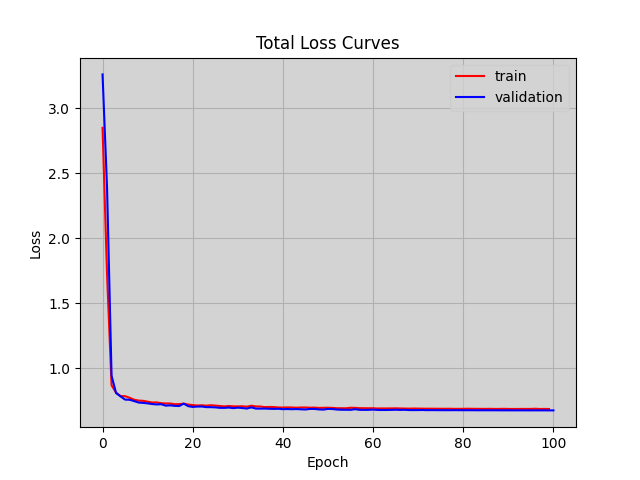

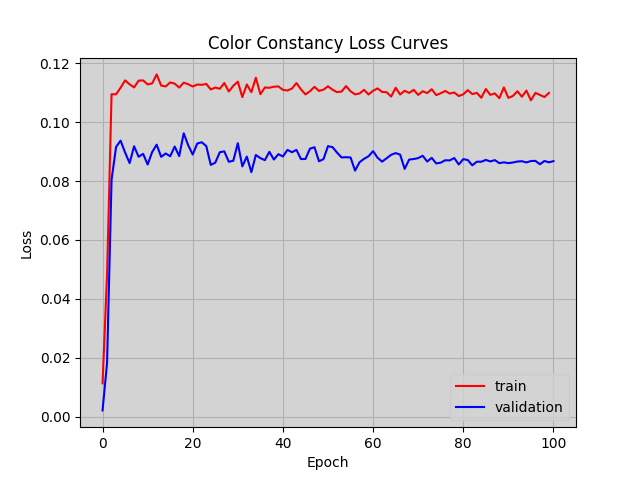

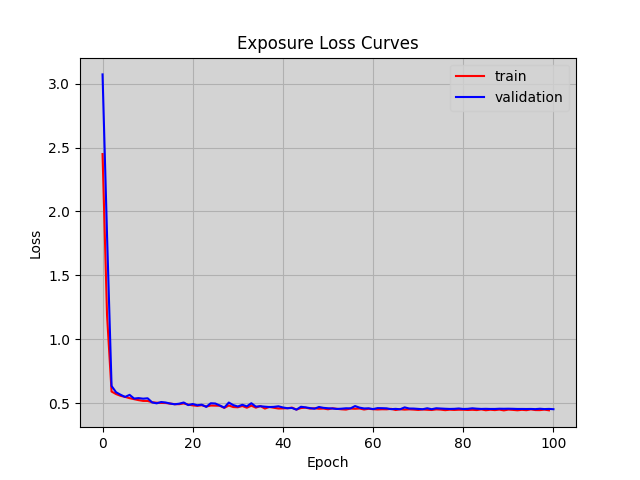

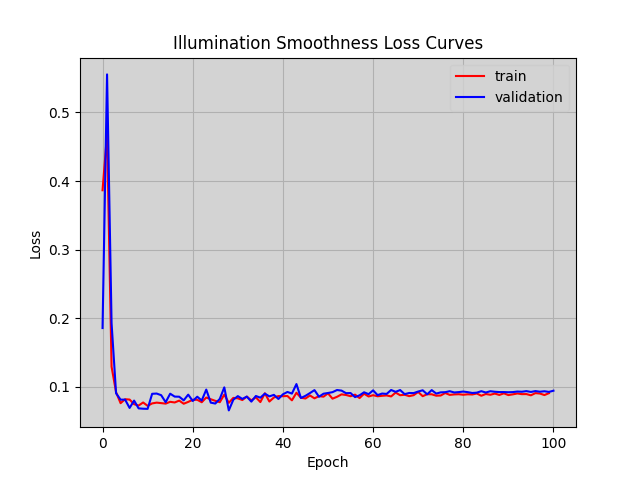

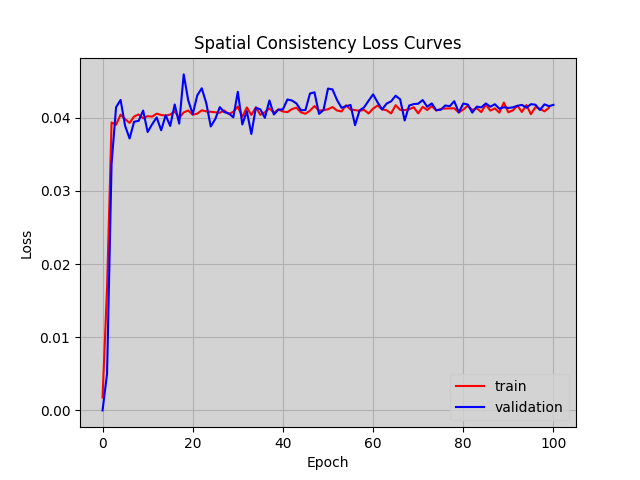

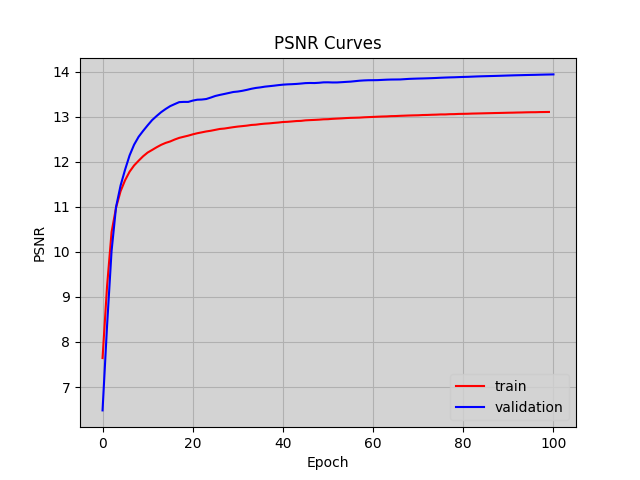

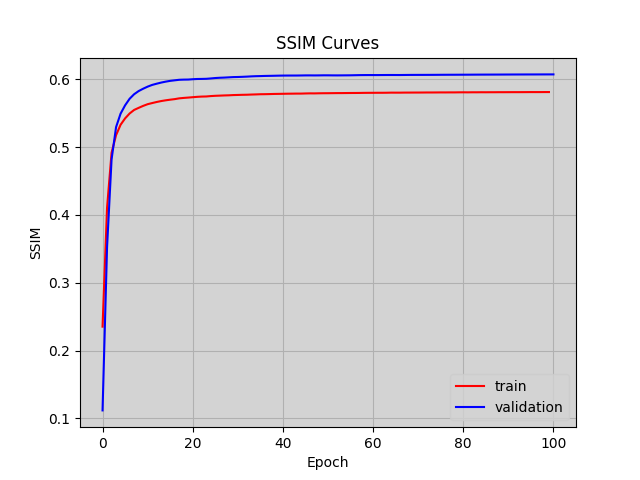

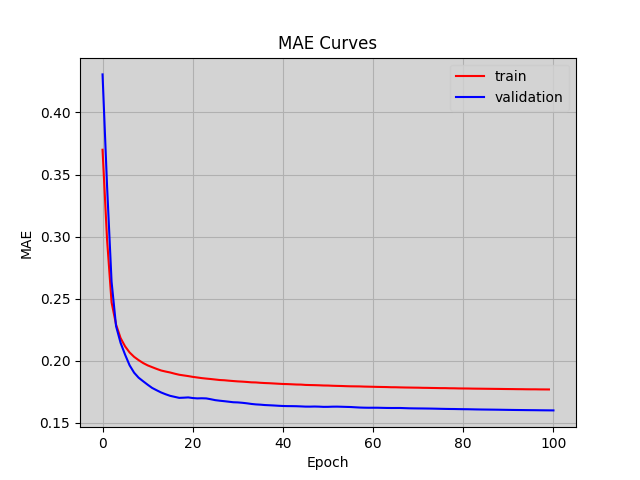

<Figure size 640x480 with 0 Axes>

In [17]:
seed_everything(SEED, workers=True)

model = MODEL()
model = ModelWrapper(model, BATCH_SIZE, LR, MAX_EPOCH)

tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_psnr',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_psnr", min_delta=0.00, patience=5, verbose=False, mode="max"
)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)

## **Testing**

In [18]:
trainer.test(ckpt_path="best")

INFO: Restoring states from the checkpoint path at /content/epoch=99-step=2400.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=99-step=2400.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=99-step=2400.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=99-step=2400.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric            ┃           DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_colorconstancy_loss     │       0.06316759437322617        │
│        test_exposure_loss        │        0.3854147791862488        │
│ test_illuminationsmoothness_loss │       0.10156912356615067        │
│             test_mae             │       0.16956301033496857        │
│            test_psnr             │        13.651941299438477        │
│   test_spatialconsistency_loss   │       0.04205112159252167        │
│            test_ssim             │        0.6623194217681885        │
│         test_total_loss          │        0.5922027230262756        │
└──────────────────────────────────┴──────────────────────────────────┘

[{'test_total_loss': 0.5922027230262756,
  'test_colorconstancy_loss': 0.06316759437322617,
  'test_exposure_loss': 0.3854147791862488,
  'test_illuminationsmoothness_loss': 0.10156912356615067,
  'test_spatialconsistency_loss': 0.04205112159252167,
  'test_psnr': 13.651941299438477,
  'test_ssim': 0.6623194217681885,
  'test_mae': 0.16956301033496857}]

In [19]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

## **Inference**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

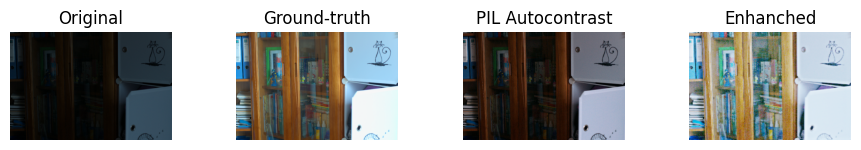

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

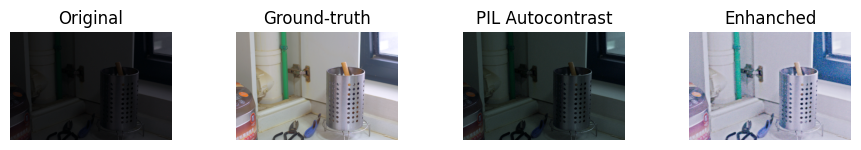

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

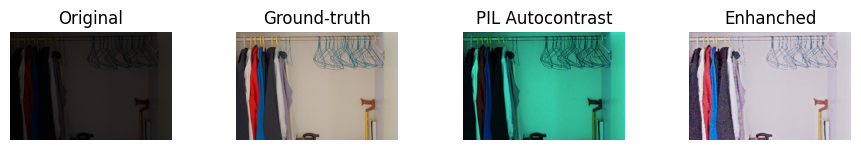

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

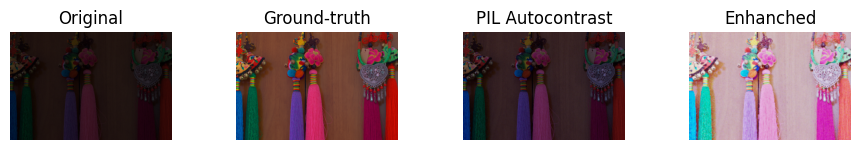

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

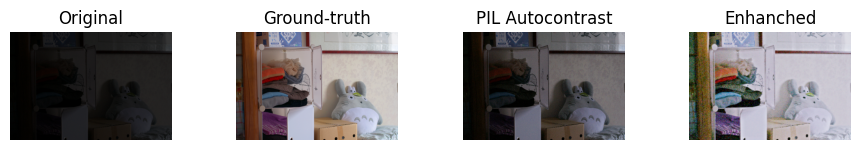

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

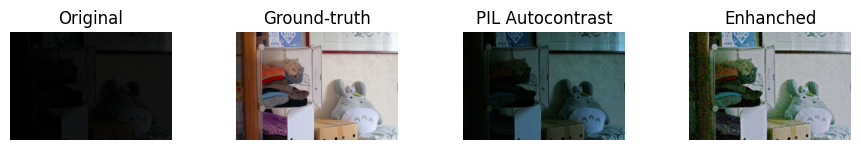

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

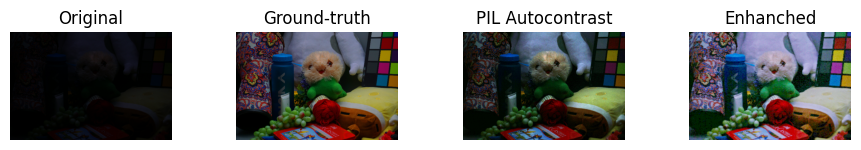

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

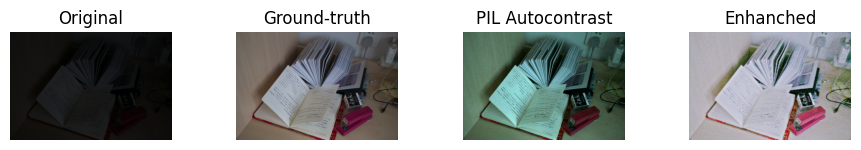

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

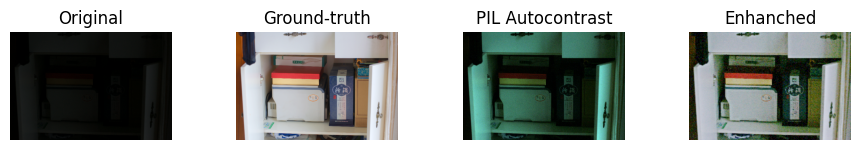

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

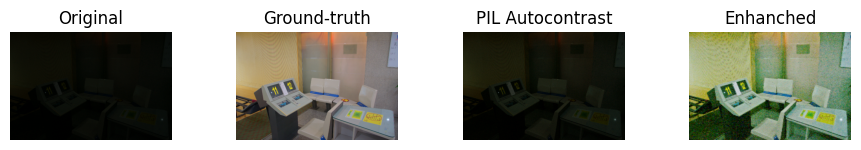

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

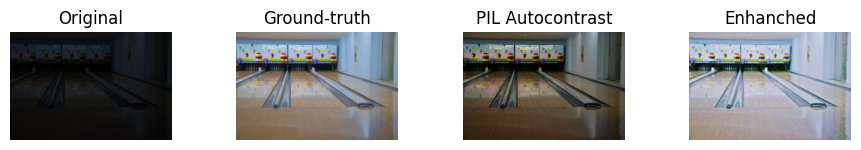

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

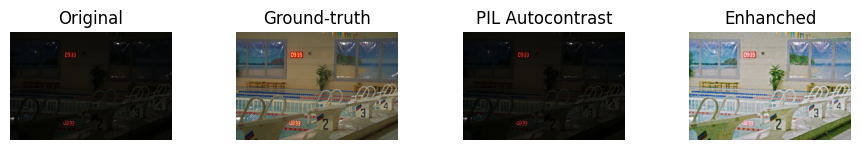

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

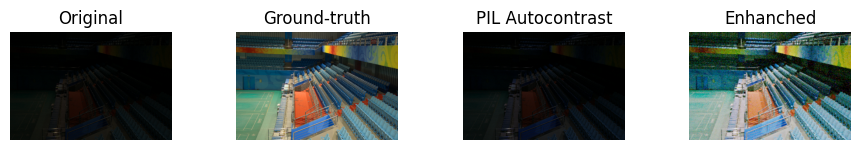

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

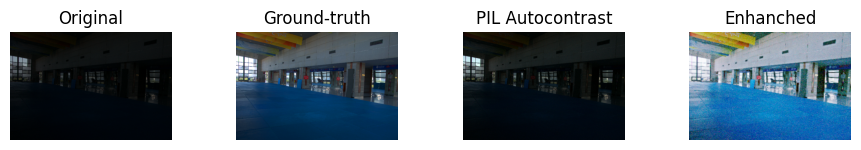

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/ZeroDCE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/ZeroDCE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Zer

Predicting: 0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

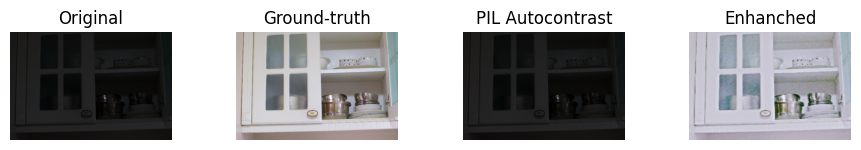

In [20]:
model.arch = trainer.strategy._lightning_module.arch

for sample_idx in range(0, len(TestDataset)):
    plt.clf()
    fig = plt.figure()
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=math.sqrt(2),
        top=math.sqrt(3),
        wspace=0.4,
        hspace=0.4,
    )
    InferenceDataset = LOLDataset(
        split="inference",
        transform=image_transform,
    )
    InferenceDataset.set_inference_index(sample_idx)
    inference_image = InferenceDataset.inference_image.copy()
    inference_image[:, :, (0, 1, 2)] = inference_image[:, :, (2, 1, 0)]

    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(inference_image.astype(np.uint8))
    ax.set_title("Original", fontsize=12)
    ax.set_axis_off()

    w = inference_image.shape[1]
    h = inference_image.shape[0]

    reference_image = InferenceDataset.inference_reference.copy()
    reference_image[:, :, (0, 1, 2)] = reference_image[:, :, (2, 1, 0)]

    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(reference_image.astype(np.uint8))
    ax.set_title("Ground-truth", fontsize=12)
    ax.set_axis_off()

    inference_image = Image.fromarray(inference_image.astype('uint8'))
    inference_image = ImageOps.autocontrast(inference_image)

    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(inference_image)
    ax.set_title("PIL Autocontrast", fontsize=12)
    ax.set_axis_off()

    trainer = Trainer()
    prediction, _ = trainer.predict(
        model=model,
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    )[0]

    prediction = prediction.permute(0, 2, 3, 1)[0, ...].data.cpu().numpy() * 255.
    prediction[:, :, (0, 1, 2)] = prediction[:, :, (2, 1, 0)]
    prediction = cv2.resize(
        prediction,
        (w, h),
        interpolation = cv2.INTER_LINEAR,
    )

    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(prediction.astype(np.uint8))
    ax.set_title("Enhanced", fontsize=12)
    ax.set_axis_off()

    plt.show()